# Main imports and code - Preparation

In [ ]:
# check which gpu we're using
!nvidia-smi

Mon Mar  4 22:23:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install simpletransformers
!pip install tensorboardx
!pip install googletrans
!pip install nltk
!pip install accelerate -U
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 9.1

In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs
from urllib import request
import pandas as pd
import logging
import torch
from collections import Counter
from ast import literal_eval

In [ ]:
# prepare logger
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# check gpu
cuda_available = torch.cuda.is_available()

print('Cuda available? ',cuda_available)

Cuda available?  True


In [ ]:
if cuda_available:
  import tensorflow as tf
  # Get the GPU device name.
  device_name = tf.test.gpu_device_name()
  # The device name should look like the following:
  if device_name == '/device:GPU:0':
      print('Found GPU at: {}'.format(device_name))
  else:
      raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


## Fetch Don't Patronize Me! data manager module

In [ ]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py


In [ ]:
#the raw dataset
!wget -O dontpatronizeme_pcl.tsv https://raw.githubusercontent.com/CRLala/NLPLabs-2024/main/Dont_Patronize_Me_Trainingset/dontpatronizeme_pcl.tsv

--2024-03-04 22:24:40--  https://raw.githubusercontent.com/CRLala/NLPLabs-2024/main/Dont_Patronize_Me_Trainingset/dontpatronizeme_pcl.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3122842 (3.0M) [text/plain]
Saving to: ‘dontpatronizeme_pcl.tsv’

dontpatronizeme_pcl 100%[===================>]   2.98M  --.-KB/s    in 0.09s   

2024-03-04 22:24:40 (33.1 MB/s) - ‘dontpatronizeme_pcl.tsv’ saved [3122842/3122842]



In [ ]:
# their training selection set - i assume it's for picking up corresponding id from the raw dataset
!wget -O train_semeval_parids-labels.csv https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/train_semeval_parids-labels.csv

--2024-03-04 22:24:40--  https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/train_semeval_parids-labels.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 241839 (236K) [text/plain]
Saving to: ‘train_semeval_parids-labels.csv’

train_semeval_parid 100%[===================>] 236.17K  --.-KB/s    in 0.03s   

2024-03-04 22:24:40 (8.01 MB/s) - ‘train_semeval_parids-labels.csv’ saved [241839/241839]



In [ ]:
#their testing selection set
!wget -O dev_semeval_parids-labels.csv https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/dev_semeval_parids-labels.csv

--2024-03-04 22:24:40--  https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/dev_semeval_parids-labels.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61151 (60K) [text/plain]
Saving to: ‘dev_semeval_parids-labels.csv’

dev_semeval_parids- 100%[===================>]  59.72K  --.-KB/s    in 0.01s   

2024-03-04 22:24:40 (5.16 MB/s) - ‘dev_semeval_parids-labels.csv’ saved [61151/61151]



In [ ]:
#testing set
!wget -O task4_test.tsv https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/TEST/task4_test.tsv

--2024-03-04 22:24:40--  https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/TEST/task4_test.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1145277 (1.1M) [text/plain]
Saving to: ‘task4_test.tsv’

task4_test.tsv      100%[===================>]   1.09M  --.-KB/s    in 0.05s   

2024-03-04 22:24:40 (21.2 MB/s) - ‘task4_test.tsv’ saved [1145277/1145277]



In [ ]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

In [ ]:
from dont_patronize_me import DontPatronizeMe

In [ ]:
dpm = DontPatronizeMe('.', 'task4_test.tsv')

In [ ]:
dpm.load_task1()
#Paragraphs with original labels of 0 or 1 are considered to be negative examples of PCL and will have the label 0 = negative.
#Paragraphs with original labels of 2, 3 or 4 are considered to be positive examples of PCL and will have the label 1 = positive.

## Load paragraph IDs

In [ ]:
trids = pd.read_csv('train_semeval_parids-labels.csv')
teids = pd.read_csv('dev_semeval_parids-labels.csv')

In [ ]:
trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)

In [ ]:
data=dpm.train_task1_df

In [ ]:
data


,par_id,art_id,keyword,country,text,label,orig_label
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0
2,3,@@16584954,immigrant,ie,"""White House press secretary Sean Spicer said ...",0,0
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0
4,5,@@1494111,refugee,ca,""""""" Just like we received migrants fleeing El ...",0,0
...,...,...,...,...,...,...,...
10464,10465,@@14297363,women,lk,"""Sri Lankan norms and culture inhibit women fr...",0,1
10465,10466,@@70091353,vulnerable,ph,He added that the AFP will continue to bank on...,0,0
10466,10467,@@20282330,in-need,ng,""""""" She has one huge platform , and informatio...",1,3
10467,10468,@@16753236,hopeless,in,""""""" Anja Ringgren Loven I ca n't find a word t...",1,4


In [ ]:
data = data.dropna()

# RAW Dataset - Q1.a & b Data Analysis Code - SAVE FOR MICHAEL

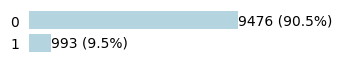

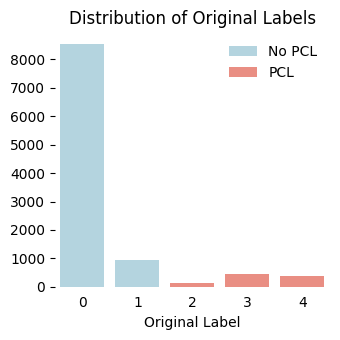

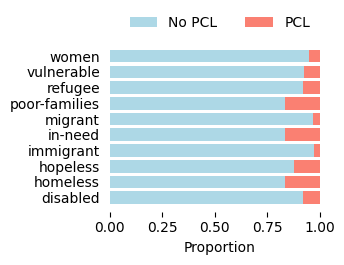

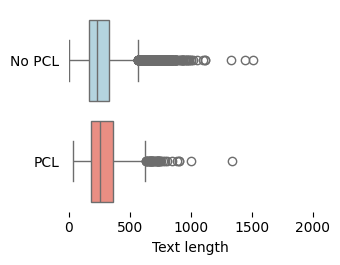

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

label_distribution = data['label'].value_counts()
label_distribution.index = label_distribution.index.astype(str)
orig_label_distribution = data['orig_label'].value_counts()
total = label_distribution.sum()

# distribution of 'label'
plt.figure(figsize=(3.5, 0.75))
barplot = sns.barplot(x=label_distribution.values, y=label_distribution.index, orient='h', color='lightblue')
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
for p in barplot.patches:
    width = p.get_width()
    count = int(width)
    percentage = f"({count / total:.1%})"
    plt.text(width + 1, p.get_y() + p.get_height() / 2, f"{count} {percentage}", ha='left', va='center', color='black')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.gca().tick_params(left=False)  # Remove y-axis tick marks
plt.tight_layout()  # Adjust the layout to make sure everything fits without overlapping
plt.savefig('distribution_of_pcl.pdf', format='pdf', bbox_inches='tight')  # Save the figure as a PDF
plt.show()

# distribution of 'orig_label'
agg_data = data.groupby('orig_label').agg(
    count=('orig_label', 'size'),
    most_common_label=('label', lambda x: x.mode()[0])
).reset_index()
agg_data['label_group'] = agg_data['most_common_label'].map({0: 'No PCL', 1: 'PCL'})
color_map = {'No PCL': 'lightblue', 'PCL': 'salmon'}
plt.figure(figsize=(3.5, 3.5))
sns.barplot(x='orig_label', y='count', hue='label_group', dodge=False,
            palette=color_map, data=agg_data)
plt.title('Distribution of Original Labels')
plt.xlabel('Original Label')
plt.ylabel('')
legend = plt.legend(title='')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.tick_params(axis='x', which='both', bottom=False, top=False)
legend.get_frame().set_edgecolor('none')  # This removes the border
plt.tight_layout()
plt.savefig('distribution_of_orig_labels_by_group.pdf', format='pdf', bbox_inches='tight')
plt.show()

# PCL by vulnerable group
keyword_label_counts = data.groupby(['keyword', 'label']).size().unstack(fill_value=0)
keyword_label_proportions = keyword_label_counts.div(keyword_label_counts.sum(axis=1), axis=0)
keyword_label_proportions.reset_index(inplace=True)
fig, ax = plt.subplots(figsize=(3.5, 2.75))
ax.barh(keyword_label_proportions['keyword'], keyword_label_proportions[0], label='No PCL', color='lightblue')
ax.barh(keyword_label_proportions['keyword'], keyword_label_proportions[1], left=keyword_label_proportions[0], label='PCL', color='salmon')
ax.set_ylabel('')
ax.set_xlabel('Proportion')
ax.set_title('')
ax.tick_params(axis='y', which='both', left=False)  # Remove y-axis tick marks
legend = ax.legend(title='', loc='lower center', bbox_to_anchor=(0.5, 1), ncol=2)
legend.get_frame().set_linewidth(0.0)  # Remove the legend border
for spine in ax.spines.values():
    spine.set_visible(False)
plt.tight_layout()
plt.savefig('pcl_by_keyword.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Box plot of paragraph length by PCL label
data['text_length'] = data['text'].apply(len)
data['label_str'] = data['label'].map({0: 'No PCL', 1: 'PCL'})
palette_colors = {'No PCL': 'lightblue', 'PCL': 'salmon'}
plt.figure(figsize=(3.5, 2.75))  # Adjust the figure size as needed
ax = sns.boxplot(x='text_length', y='label_str', hue='label_str', data=data, orient='h',
                 palette={'No PCL': 'lightblue', 'PCL': 'salmon'}, dodge=False, legend=False)
plt.title('')
plt.xlabel('Text length')
plt.ylabel('')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xlim(0, 2000)
ax.tick_params(axis='y', which='both', left=False)  # Remove y-axis tick marks
plt.tight_layout()
plt.savefig('pcl_by_length.pdf', format='pdf', bbox_inches='tight')
plt.show()



## Get the raw training set (Task 1) - without split

In [ ]:
rows = [] # will contain par_id, label and text
for idx in range(len(trids)):
  parid = trids.par_id[idx]
  #print(parid)
  # select row from original dataset to retrieve `text` and binary label
  keyword = data.loc[data.par_id == parid].keyword.values[0]
  text = data.loc[data.par_id == parid].text.values[0]
  label = data.loc[data.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'community':keyword,
      'text':text,
      'label':label
  })


In [ ]:
import random

In [ ]:
trdf1 = pd.DataFrame(rows)

In [ ]:
trdf1

,par_id,community,text,label
0,4341,poor-families,"The scheme saw an estimated 150,000 children f...",1
1,4136,homeless,Durban 's homeless communities reconciliation ...,1
2,10352,poor-families,The next immediate problem that cropped up was...,1
3,8279,vulnerable,Far more important than the implications for t...,1
4,1164,poor-families,To strengthen child-sensitive social protectio...,1
...,...,...,...,...
8370,8380,refugee,Rescue teams search for survivors on the rubbl...,0
8371,8381,hopeless,The launch of ' Happy Birthday ' took place la...,0
8372,8382,homeless,"The unrest has left at least 20,000 people dea...",0
8373,8383,hopeless,You have to see it from my perspective . I may...,0


In [ ]:
trdf1.to_csv("trdf1.csv")

## get the raw test set (Task 1)

In [ ]:
rows = [] # will contain par_id, label and text
for idx in range(len(teids)):
  parid = teids.par_id[idx]
  #print(parid)
  # select row from original dataset
  keyword = data.loc[data.par_id == parid].keyword.values[0]
  text = data.loc[data.par_id == parid].text.values[0]
  label = data.loc[data.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'community':keyword,
      'text':text,
      'label':label
  })


In [ ]:
len(rows)

2094

In [ ]:
tedf1 = pd.DataFrame(rows)
#print(tedf1)

In [ ]:
random.shuffle(tedf1.text.tolist())
tedf1.to_csv("tedf1.csv")
#shuffled_tedf1 = tedf1.sample(frac=1).reset_index(drop=True)

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix


def evaluate_model(true_labels, preds):
    f1 = f1_score(true_labels, preds)
    accuracy = accuracy_score(true_labels, preds)
    precision = precision_score(true_labels, preds)
    recall = recall_score(true_labels, preds)
    conf_matrix = confusion_matrix(true_labels, preds)
    print(f"F1 Score: {f1}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")


    print("Confusion Matrix:")
    print(conf_matrix)



## Baseline for Task 1

In [ ]:
print(len(trdf1[trdf1.label==0]))
print(len(trdf1[trdf1.label==1]))
print((len(trdf1[trdf1.label==0]))/len(trdf1[trdf1.label==1]))

7581
794
9.547858942065492


Neg is 10 times more than positive class.

### RoBERTa Negative : Positive = 2:1

- non-pcl : pcl = 2:1
- 46.7% F1 on offical dev set

In [ ]:
# downsample negative instances
pcldf = trdf1[trdf1.label==1]
npos = len(pcldf)
#0, limited to twice the number of positive examples
training_set1 = pd.concat([pcldf,trdf1[trdf1.label==0][:npos*2]])

In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs

results = []

for seed in [random.randint(1, 100) for _ in range(10)]:
    for base in ['roberta', 'deberta']:
        baseline = base

        task1_model_args = ClassificationArgs(num_train_epochs=1,
                                            no_save=True,
                                            no_cache=True,
                                            manual_seed = seed,
                                            overwrite_output_dir=True,
                                            use_multiprocessing=False,
                                            use_multiprocessing_for_evaluation=False)
        if baseline == 'roberta':
            task1_model = ClassificationModel("roberta",
                                            'roberta-base',
                                            args = task1_model_args,
                                            num_labels=2,
                                            use_cuda=cuda_available)
        elif baseline == 'deberta':
            task1_model = ClassificationModel("deberta",
                                            'microsoft/deberta-base',
                                            args = task1_model_args,
                                            num_labels=2,
                                            use_cuda=cuda_available)
        else:
            print("Please enter valid model to take as a baseline")
        task1_model.train_model(training_set1[['text', 'label']])
        preds_task1, _ = task1_model.predict(tedf1.text.tolist())
        true_labels = tedf1.label.tolist()
        f1 = f1_score(true_labels, preds_task1)
        results_tuple = (base, seed, f1)
        results.append(results_tuple)
results = pd.DataFrame(results, columns=['Model', 'Seed', 'F1'])
Creating boxplot
plt.figure(figsize=(3.5, 2.75))
ax = sns.boxplot(x='F1', y='Model', hue='Model', data=results, dodge=False, legend=False,
            palette={'roberta': 'lightblue', 'deberta': 'salmon'})
plt.title('')
plt.xlabel('F1 Score')
plt.ylabel('')
plt.tight_layout()
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(axis='y', which='both', left=False)  # Remove y-axis tick marks
plt.savefig('avg_berta_performance.pdf', format='pdf', bbox_inches='tight')
plt.show()
torch.cuda.memory_allocated()
torch.cuda.empty_cache()
del task1_model
del preds_task1
del true_labels
torch.cuda.memory_allocated()

# Prepare submission

In [ ]:
!cat dev.txt | head -n 10

0
1
0
1
0
0
1
1
0
0


In [ ]:
!zip submission.zip dev.txt test.txt

  adding: dev.txt (deflated 95%)
  adding: test.txt (deflated 95%)


In [ ]:
!cat test.txt | head -n 10

0
0
0
0
0
0
0
0
0
0
